Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 🔎 Agent Observability - Logs, Traces & Metrics

**Welcome to Day 4 of the Kaggle 5-day Agents course!**

In Day 3, you learned the **"What, Why & How" of Session and Memory management**, focusing on long-term, short-term, and shared memory (state). 

Today, you'll learn:
- How to add observability to the agent you've built and
- How to evaluate if the agents are working as expected

In this notebook, we'll focus on the first part - **Agent Observability!**

## What is Agent Observability?

**🚨 The challenge:** Unlike traditional software that fails predictably, AI agents can fail mysteriously. Example:

```
User: "Find quantum computing papers"
Agent: "I cannot help with that request."
You: 😭 WHY?? Is it the prompt? Missing tools? API error?
```

**💡 The Solution:** Agent observability gives you complete visibility into your agent's decision-making process. You'll see exactly what prompts are sent to the LLM, which tools are available, how the model responds, and where failures occur.

```
DEBUG Log: LLM Request shows "Functions: []" (no tools!)
You: 🎯 Aha! Missing google_search tool - easy fix!
```

## Foundational pillars of Agent Observability

1. **Logs:** A log is a record of a single event, telling you **what** happened at a specific moment.
2. **Traces:** A trace connects the logs into a single story, showing you **why** a final result occurred by revealing the entire sequence of steps.
3. **Metrics:** Metrics are the summary numbers (like averages and error rates) that tell you **how** well the agent is performing overall.

<center>
    <img src="https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/observability-intro.png">
</center>

**In this notebook, you'll:**

* ✅ Set up logging configuration
* ✅ Create a broken agent. Use `adk web` UI & logs to identify exactly why the agent fails
* ✅ Understand how to implement logging in production
* ✅ Learn when to use built-in logging vs custom solutions

## ‼️ Please Read

> ❌ **ℹ️ Note: No submission required!**
> This notebook is for your hands-on practice and learning only. You **do not** need to submit it anywhere to complete the course.

> ⏸️ **Note:**  When you first start the notebook via running a cell you might see a banner in the notebook header that reads **"Waiting for the next available notebook"**. The queue should drop rapidly; however, during peak bursts you might have to wait a few minutes.

> ❌ **Note:** Avoid using the **Run all** cells command as this can trigger a QPM limit resulting in 429 errors when calling the backing model. Suggested flow is to run each cell in order - one at a time. [See FAQ on 429 errors for more information.](https://www.kaggle.com/code/kaggle5daysofai/day-0-troubleshooting-and-faqs)

**For help: Ask questions on the [Kaggle Discord](https://discord.com/invite/kaggle) server.**

## ⚙️ Section 1: Setup

### 1.1: Install dependencies

The Kaggle Notebooks environment includes a pre-installed version of the [google-adk](https://google.github.io/adk-docs/) library for Python and its required dependencies, so you don't need to install additional packages in this notebook.

To install and use ADK in your own Python development environment outside of this course, you can do so by running:

```
pip install google-adk
```

### 🔑 1.2: Configure your Gemini API Key

This notebook uses the [Gemini API](https://ai.google.dev/gemini-api/), which requires an API key.

**1. Get your API key**

If you don't have one already, create an [API key in Google AI Studio](https://aistudio.google.com/app/api-keys).

**2. Add the key to Kaggle Secrets**

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

1. In the top menu bar of the notebook editor, select `Add-ons` then `Secrets`.
2. Create a new secret with the label `GOOGLE_API_KEY`.
3. Paste your API key into the "Value" field and click "Save".
4. Ensure that the checkbox next to `GOOGLE_API_KEY` is selected so that the secret is attached to the notebook.

**3. Authenticate in the notebook**

Run the cell below to access the `GOOGLE_API_KEY` you just saved and set it as an environment variable for the notebook to use:

In [1]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Setup and authentication complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Setup and authentication complete.


### ✍️ 1.3: Set up logging and cleanup old files
Let's configure logging for our debugging session. The following cell makes sure we also capture other log levels, like DEBUG.

In [2]:
import logging
import os

# Clean up any previous logs
for log_file in ["logger.log", "web.log", "tunnel.log"]:
    if os.path.exists(log_file):
        os.remove(log_file)
        print(f"🧹 Cleaned up {log_file}")

# Configure logging with DEBUG log level.
logging.basicConfig(
    filename="logger.log",
    level=logging.DEBUG,
    format="%(filename)s:%(lineno)s %(levelname)s:%(message)s",
)

print("✅ Logging configured")

✅ Logging configured


### 💻 1.4: Set up proxy and tunneling

We'll use a proxy to access the ADK web UI from within the Kaggle Notebooks environment. If you are running this outside the Kaggle environment, you don't need to do this.

In [3]:
from IPython.core.display import display, HTML
from jupyter_server.serverapp import list_running_servers


# Gets the proxied URL in the Kaggle Notebooks environment
def get_adk_proxy_url():
    PROXY_HOST = "https://kkb-production.jupyter-proxy.kaggle.net"
    ADK_PORT = "8000"

    servers = list(list_running_servers())
    if not servers:
        raise Exception("No running Jupyter servers found.")

    baseURL = servers[0]["base_url"]

    try:
        path_parts = baseURL.split("/")
        kernel = path_parts[2]
        token = path_parts[3]
    except IndexError:
        raise Exception(f"Could not parse kernel/token from base URL: {baseURL}")

    url_prefix = f"/k/{kernel}/{token}/proxy/proxy/{ADK_PORT}"
    url = f"{PROXY_HOST}{url_prefix}"

    styled_html = f"""
    <div style="padding: 15px; border: 2px solid #f0ad4e; border-radius: 8px; background-color: #fef9f0; margin: 20px 0;">
        <div style="font-family: sans-serif; margin-bottom: 12px; color: #333; font-size: 1.1em;">
            <strong>⚠️ IMPORTANT: Action Required</strong>
        </div>
        <div style="font-family: sans-serif; margin-bottom: 15px; color: #333; line-height: 1.5;">
            The ADK web UI is <strong>not running yet</strong>. You must start it in the next cell.
            <ol style="margin-top: 10px; padding-left: 20px;">
                <li style="margin-bottom: 5px;"><strong>Run the next cell</strong> (the one with <code>!adk web ...</code>) to start the ADK web UI.</li>
                <li style="margin-bottom: 5px;">Wait for that cell to show it is "Running" (it will not "complete").</li>
                <li>Once it's running, <strong>return to this button</strong> and click it to open the UI.</li>
            </ol>
            <em style="font-size: 0.9em; color: #555;">(If you click the button before running the next cell, you will get a 500 error.)</em>
        </div>
        <a href='{url}' target='_blank' style="
            display: inline-block; background-color: #1a73e8; color: white; padding: 10px 20px;
            text-decoration: none; border-radius: 25px; font-family: sans-serif; font-weight: 500;
            box-shadow: 0 2px 5px rgba(0,0,0,0.2); transition: all 0.2s ease;">
            Open ADK Web UI (after running cell below) ↗
        </a>
    </div>
    """

    display(HTML(styled_html))

    return url_prefix


print("✅ Helper functions defined.")

✅ Helper functions defined.


---
## 🐞 Section 2: Hands-On Debugging with ADK Web UI

### 2.1: Create a "Research Paper Finder" Agent


**Our goal:** Build a research paper finder agent that helps users find academic papers on any topic.

But first, let's intentionally create an incorrect version of the agent to practice debugging! We'll start by creating a new agent folder using the `adk create` CLI command.

In [4]:
!adk create research-agent --model gemini-2.5-flash-lite --api_key $GOOGLE_API_KEY


Agent created in /kaggle/working/research-agent:
- .env
- __init__.py
- agent.py



### Agent definition

Next, let's create our root agent. 
- We'll configure it as an `LlmAgent`, give it a name, model and instruction.
- The `root_agent` gets the user prompt and delegates the search to the `google_search_agent`.
- Then, the agent uses the `count_papers` tool to count the number of papers returned.

**👉 Pay attention to the root agent's instructions and the `count_papers` tool parameter!**

In [10]:
%%writefile research-agent/agent.py

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.tools.agent_tool import AgentTool
from google.adk.tools.google_search_tool import google_search

from google.genai import types
from typing import List

retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)

# ---- Intentionally pass incorrect datatype - `str` instead of `List[str]` ----
def count_papers(papers: List[str]):
    """
    This function counts the number of papers in a list of strings.
    Args:
      papers: A list of strings, where each string is a research paper.
    Returns:
      The number of papers in the list.
    """
    return len(papers)


# Google Search agent
google_search_agent = LlmAgent(
    name="google_search_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    description="Searches for information using Google search",
    instruction="""Use the google_search tool to find information on the given topic. Return the raw search results.
    If the user asks for a list of papers, then give them the list of research papers you found and not the summary.""",
    tools=[google_search]
)


# Root agent
root_agent = LlmAgent(
    name="research_paper_finder_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""Your task is to find research papers and count them. 

    You MUST ALWAYS follow these steps:
    1) Find research papers on the user provided topic using the 'google_search_agent'. 
    2) Then, pass the papers to 'count_papers' tool to count the number of papers returned.
    3) Return both the list of research papers and the total number of papers.
    """,
    tools=[AgentTool(agent=google_search_agent), count_papers]
)

Overwriting research-agent/agent.py


### 2.2: Run the agent

Let's now run our agent with the `adk web --log_level DEBUG` CLI command.

**📍 The key here is `--log_level DEBUG`** - this shows us:


* **Full LLM Prompts:** The complete request sent to the language model, including system instructions, history, and tools.
* Detailed API responses from services.
* Internal state transitions and variable values.

Other log levels include: INFO, ERROR and WARNING.

Get the proxied URL to access the ADK web UI in the Kaggle Notebooks environment:

In [11]:
url_prefix = get_adk_proxy_url()

Now you can start the ADK web UI with the `--log_level` parameter.

👉 **Note:** The following cell will not "complete", but will remain running and serving the ADK web UI until you manually stop the cell.

In [12]:
!adk web --log_level DEBUG --url_prefix {url_prefix}

/usr/local/lib/python3.11/dist-packages/google/adk/cli/fast_api.py:130: UserWarning: [EXPERIMENTAL] InMemoryCredentialService: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  credential_service = InMemoryCredentialService()
/usr/local/lib/python3.11/dist-packages/google/adk/auth/credential_service/in_memory_credential_service.py:33: UserWarning: [EXPERIMENTAL] BaseCredentialService: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__()
INFO:     Started server process [107]
INFO:     Waiting for application startup.

+-----------------------------------------------------------------------------+
| ADK Web Server started                                                      |
|                                                                             |
| For local testing, access at http:

Once the ADK web UI starts, open the proxy link using the button in the previous cell.

As you start chatting with the agent, you should see the DEBUG logs appear in the output cell below!

‼️ **IMPORTANT: DO NOT SHARE THE PROXY LINK** with anyone - treat it as sensitive data as it contains your authentication token in the URL.

### 📝 2.3: Test the agent in ADK web UI

#### **👉 Do: In the ADK web UI**

1. Select "research-agent" from the dropdown in the top-left.
2. In the chat interface, type: `Find latest quantum computing papers`
3. Send the message and observe the response. The agent should return a list of research papers and their count.

It looks like our agent works and we got a response! 🤔 **But wait, isn't the count of papers unusually large? Let's look at the logs and trace.** 

#### **👉 Do: Events tab - Traces in detail**

1. In the web UI, click the **"Events"** tab on the left sidebar
2. You'll see a chronological list of all agent actions
3. Click on any event to expand its details in the bottom panel
4. Try clicking the **"Trace"** button to see timing information for each step.
5. **Click the `execute_tool count_papers` span. You'll see that the function call to `count_papers` returns the large number as the response**.
6. Let's look at what was passed as input to this function. 
7. **Find the `call_llm` span corresponding to the `count_papers` function call**.

#### **👉 Do: Inspect the Function call in Events:**

- Click on the specific span to open the Events tab.
- Examine the `function_call`, focusing on the `papers` argument.
- Notice that `root_agent` passes the list of `papers` as a **str** instead of a **List[str]** - there's our bug! 

![Demo](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/observability-demo.gif)

### 2.4: Your Turn - fix it! 👾 

Update the datatype of the `papers` argument in the `count_papers` tool to a `List[str]` and rerun the `adk web` command!

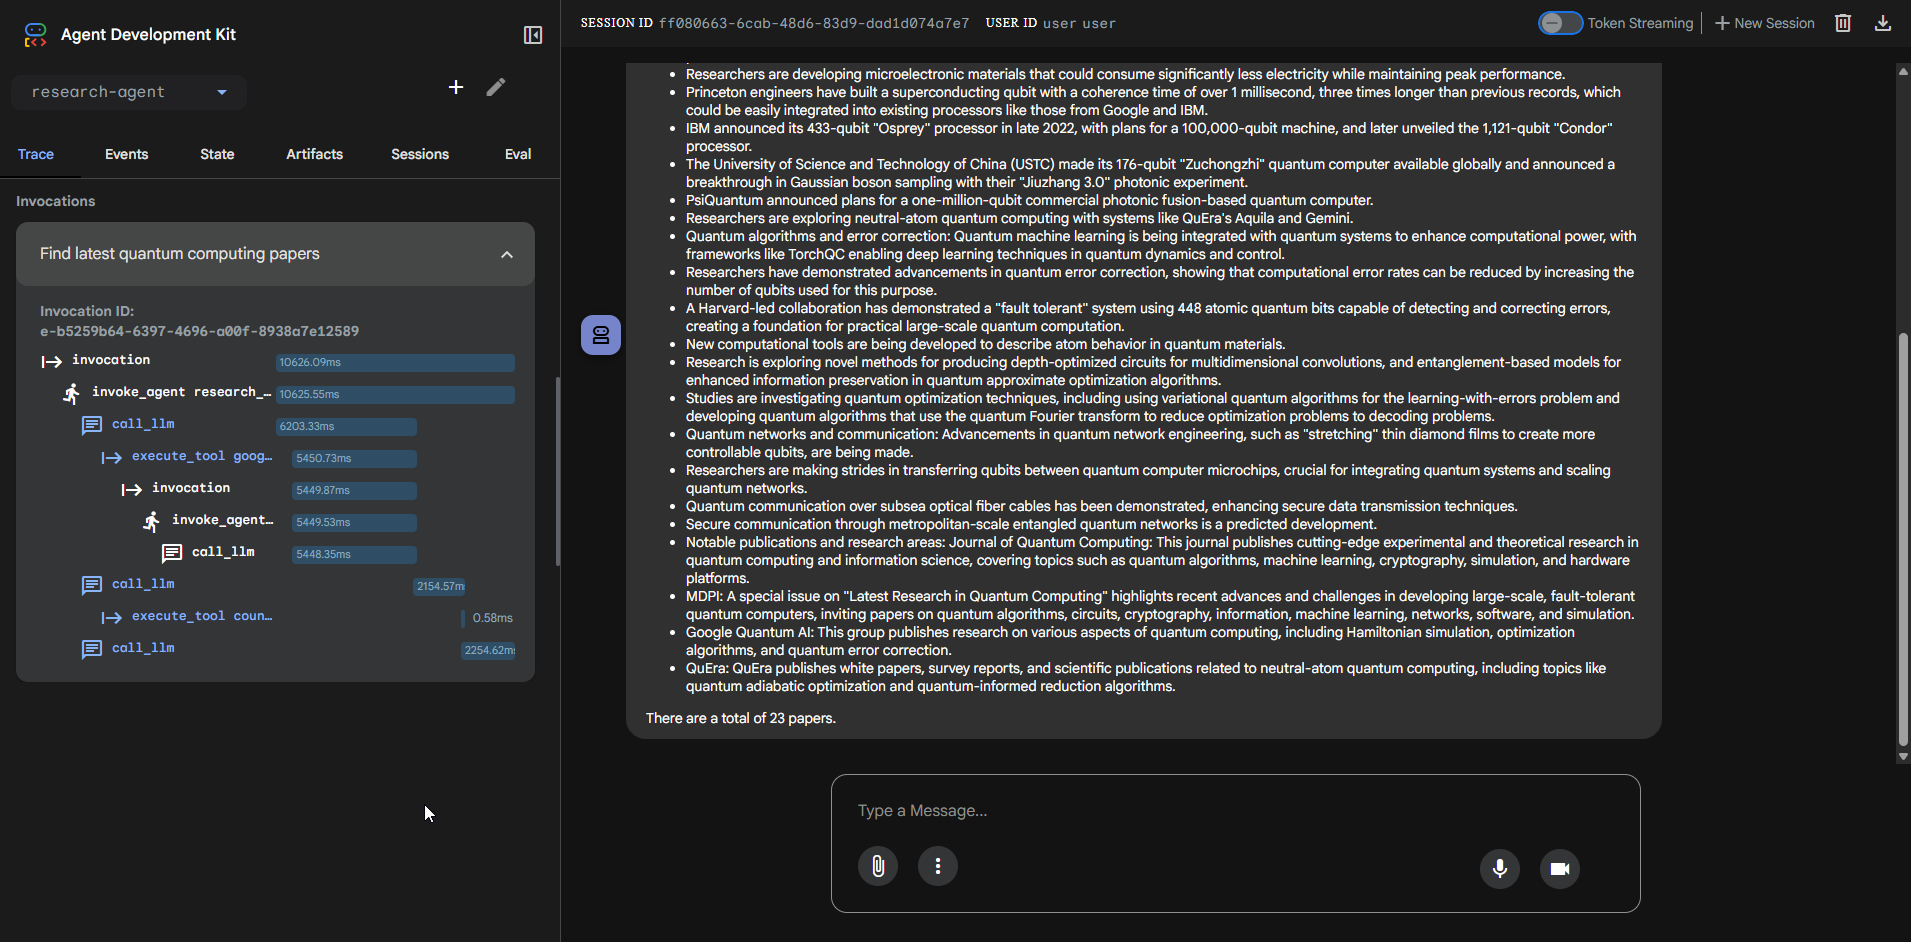

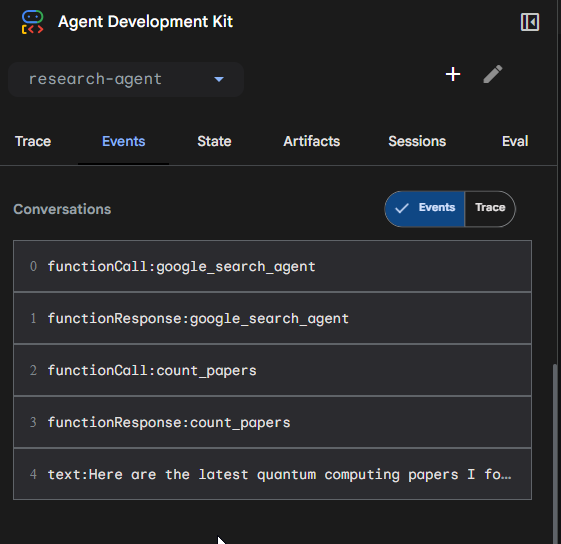

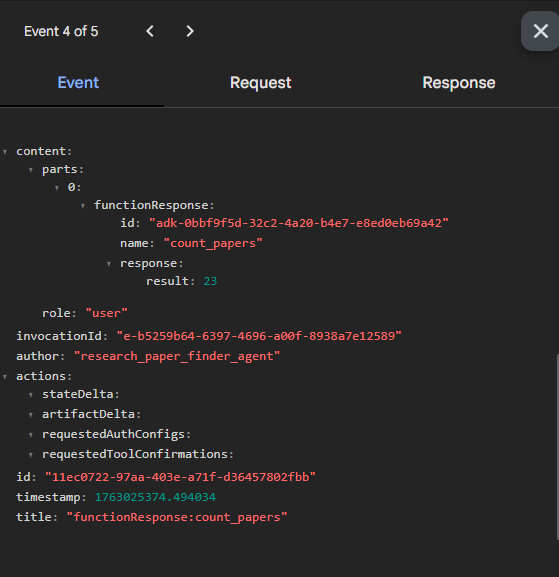



---

## ‼️ **Stop the ADK web UI** 🛑

**In order to run cells in the remainder of this notebook,** please stop the running cell where you started `adk web` in Section 3.1.

Otherwise that running cell will block / prevent other cells from running as long as the ADK web UI is running.

---

### 2.5: Debug through local Logs

Optionally, you can also examine the local DEBUG logs to find the root cause. Run the following cell to print the contents of the log file. Look for detailed logs like:
```
DEBUG - google_adk.models.google_llm - LLM Request: ...
DEBUG - google_adk.models.google_llm - LLM Response: ...
```

In [14]:
# Check the DEBUG logs from the broken agent
print("🔍 Examining web server logs for debugging clues...\n")
!cat logger.log

🔍 Examining web server logs for debugging clues...



**Other Observability questions you can now answer from logs and adk web:**
- **Efficiency**: Is the agent making optimal tool choices?
- **Reasoning Quality**: Are the prompts well-structured and context-appropriate?
- **Performance**: Look at the traces to identify which steps take the longest?
- **Failure Diagnosis**: When something goes wrong, where exactly did it fail?

**Key Learning:** Core debugging pattern: `symptom → logs → root cause → fix`.

**Debugging Victory:** You just went from "Agent mysteriously failed" to "I know exactly why and how to fix it!" This is the power of observability!


---
## 🧑‍💻 Section 3: Logging in production

**🎯 Great! You can now debug agent failures using ADK web UI and DEBUG logs.**

But what happens when you move beyond development? Real-world scenarios where you need to move beyond the web UI:

**❌ Problem 1: Production Deployment**
```
You: "Let me open the ADK web UI to check why the agent failed"
DevOps: "Um... this is a production server. No web UI access."
You: 😱 "How do I debug production issues?"
```

**❌ Problem 2: Automated Systems** 
```
You: "The agent runs 1000 times per day in our pipeline"
Boss: "Which runs are slow? What's our success rate?"
You: 😰 "I'd have to manually check the web UI 1000 times..."
```

**💡 The Solution:**

We need a way to capture observability data or in other words, **add logs to our code**. 

👉 In traditional software development, this is done by adding log statements in Python functions - **and agents are no different!** We need to add log statements to our agent and a common approach is to add log statements to **Plugins**.


### 3.1: How to add logs for production observability?

A Plugin is a custom code module that runs automatically at various stages of your agent's lifecycle. Plugins are composed of "**Callbacks**" which provide the hooks to interrupt an agent's flow. Think of it like this:

- **Your agent workflow**: User message → Agent thinks → Calls tools → Returns response
- **Plugin hooks into this**: Before agent starts → After tool runs → When LLM responds → etc.
- **Plugin contains your custom code**: Logging, monitoring, security checks, caching, etc.

![image.png](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/plugins-callbacks.png)

#### Callbacks

Callbacks are the **atomic components inside a Plugin** - these are just Python functions that run at specific points in an agent's lifecycle! **Callbacks are grouped together to create a Plugin.**

There are different kinds of callbacks such as:
* **before/after_agent_callbacks** - runs before/after an agent is invoked
* **before/after_tool_callbacks** - runs before/after a tool is called
* **before/after_model_callbacks** - similarly, runs before/after the LLM model is called
* **on_model_error_callback** - which runs when a model error is encountered

![image.png](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/types_of_callbacks.png)

### 3.2: To make things more concrete, what does a Plugin look like?

In [15]:
print("----- EXAMPLE PLUGIN - DOES NOTHING ----- ")

import logging
from google.adk.agents.base_agent import BaseAgent
from google.adk.agents.callback_context import CallbackContext
from google.adk.models.llm_request import LlmRequest
from google.adk.plugins.base_plugin import BasePlugin


# Applies to all agent and model calls
class CountInvocationPlugin(BasePlugin):
    """A custom plugin that counts agent and tool invocations."""

    def __init__(self) -> None:
        """Initialize the plugin with counters."""
        super().__init__(name="count_invocation")
        self.agent_count: int = 0
        self.tool_count: int = 0
        self.llm_request_count: int = 0

    # Callback 1: Runs before an agent is called. You can add any custom logic here.
    async def before_agent_callback(
        self, *, agent: BaseAgent, callback_context: CallbackContext
    ) -> None:
        """Count agent runs."""
        self.agent_count += 1
        logging.info(f"[Plugin] Agent run count: {self.agent_count}")

    # Callback 2: Runs before a model is called. You can add any custom logic here.
    async def before_model_callback(
        self, *, callback_context: CallbackContext, llm_request: LlmRequest
    ) -> None:
        """Count LLM requests."""
        self.llm_request_count += 1
        logging.info(f"[Plugin] LLM request count: {self.llm_request_count}")

----- EXAMPLE PLUGIN - DOES NOTHING ----- 


**Key insight**: You register a plugin **once** on your runner, and it automatically applies to **every agent, tool call, and LLM request** in your system as per your definition. Read more about Plugin hooks [here](https://google.github.io/adk-docs/plugins/#plugin-callback-hooks).

You can follow along with the numbers in the diagram below to understand the flow.

![image.png](https://storage.googleapis.com/github-repo/kaggle-5days-ai/day4/count-invocation-plugin.png)

### 3.3: ADK's built-in `LoggingPlugin`

But you don't have to define all the callbacks and plugins to capture *standard* Observability data in ADK. Instead, ADK provides a built-in **LoggingPlugin** that automatically captures all agent activity:

- 🚀 User messages and agent responses
- ⏱️ Timing data for performance analysis
- 🧠 LLM requests and responses for debugging
- 🔧 Tool calls and results
- ✅ Complete execution traces

#### Agent definition

Let's use the same agent from the previous demo - the Research paper finder!

In [16]:
from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.tools.agent_tool import AgentTool
from google.adk.tools.google_search_tool import google_search

from google.genai import types
from typing import List

retry_config = types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504],  # Retry on these HTTP errors
)


def count_papers(papers: List[str]):
    """
    This function counts the number of papers in a list of strings.
    Args:
      papers: A list of strings, where each string is a research paper.
    Returns:
      The number of papers in the list.
    """
    return len(papers)


# Google search agent
google_search_agent = LlmAgent(
    name="google_search_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    description="Searches for information using Google search",
    instruction="Use the google_search tool to find information on the given topic. Return the raw search results.",
    tools=[google_search],
)

# Root agent
research_agent_with_plugin = LlmAgent(
    name="research_paper_finder_agent",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""Your task is to find research papers and count them. 
   
   You must follow these steps:
   1) Find research papers on the user provided topic using the 'google_search_agent'. 
   2) Then, pass the papers to 'count_papers' tool to count the number of papers returned.
   3) Return both the list of research papers and the total number of papers.
   """,
    tools=[AgentTool(agent=google_search_agent), count_papers],
)

print("✅ Agent created")

✅ Agent created


### 3.4: Add LoggingPlugin to Runner

The following code creates the `InMemoryRunner`. This is used to programmatically invoke the agent.

**To use `LoggingPlugin` in the above research agent,**
1) Import the plugin
2) Add it when initializing the `InMemoryRunner`.


In [17]:
from google.adk.runners import InMemoryRunner
from google.adk.plugins.logging_plugin import (
    LoggingPlugin,
)  # <---- 1. Import the Plugin
from google.genai import types
import asyncio

runner = InMemoryRunner(
    agent=research_agent_with_plugin,
    plugins=[
        LoggingPlugin()
    ],  # <---- 2. Add the plugin. Handles standard Observability logging across ALL agents
)

print("✅ Runner configured")

✅ Runner configured


Let's now run the agent using `run_debug` function.

In [18]:
print("🚀 Running agent with LoggingPlugin...")
print("📊 Watch the comprehensive logging output below:\n")

response = await runner.run_debug("Find recent papers on quantum computing")

🚀 Running agent with LoggingPlugin...
📊 Watch the comprehensive logging output below:


 ### Created new session: debug_session_id

User > Find recent papers on quantum computing
[logging_plugin] 🚀 USER MESSAGE RECEIVED
[logging_plugin]    Invocation ID: e-f127c969-85d4-4516-810c-e915f21e622d
[logging_plugin]    Session ID: debug_session_id
[logging_plugin]    User ID: debug_user_id
[logging_plugin]    App Name: InMemoryRunner
[logging_plugin]    Root Agent: research_paper_finder_agent
[logging_plugin]    User Content: text: 'Find recent papers on quantum computing'
[logging_plugin] 🏃 INVOCATION STARTING
[logging_plugin]    Invocation ID: e-f127c969-85d4-4516-810c-e915f21e622d
[logging_plugin]    Starting Agent: research_paper_finder_agent
[logging_plugin] 🤖 AGENT STARTING
[logging_plugin]    Agent Name: research_paper_finder_agent
[logging_plugin]    Invocation ID: e-f127c969-85d4-4516-810c-e915f21e622d
[logging_plugin] 🧠 LLM REQUEST
[logging_plugin]    Model: gemini-2.5-flash-lite
[l

---

## 📊 Summary

**❓ When to use which type of Logging?**
1. **Development debugging?** → Use `adk web --log_level DEBUG`
2. **Common production observability?** → Use `LoggingPlugin()` 
3. **Custom requirements?** → Build Custom Callbacks and Plugins

### Try it out!

👉 Extend the agent's observability by implementing a **custom ADK plugin** that tracks and reports the total number of tool calls made during a session.

## 🎯 Congratulations!

**You now know how to:**

- ✅ Debug agent failures through DEBUG logs and the ADK web UI
- ✅ Use the core debugging pattern: symptom → logs → root cause → fix  
- ✅ Scale observability with `LoggingPlugin` for production systems
- ✅ Understand when to use the different logging types

**ℹ️ Note: No submission required!**

This notebook is for your hands-on practice and learning only. You **do not** need to submit it anywhere to complete the course.

### 📚 Resources

**Refer to the ADK documentation to learn more about observability:**

- [ADK Observability Documentation](https://google.github.io/adk-docs/observability/logging/) - Complete guide to logging in ADK
- [Custom Plugin](https://google.github.io/adk-docs/plugins/) - Build your own Plugins
- [External Integrations](https://google.github.io/adk-docs/observability/cloud-trace/) - Explore external third-party observability integrations with ADK

### 🎯 Next Steps

Ready for the next challenge? Continue to the next notebook to learn how to **Evaluate an Agent** and ensure it's working as expected in production.

---

<div align="center">
  <table>
    <tr>
      <th style="text-align:center">Authors</th>
    </tr>
    <tr>
      <td style="text-align:center"><a href="https://www.linkedin.com/in/sitalakshmi04/">Sita Lakshmi Sangameswaran</a></td>
    </tr>
  </table>
</div>